In [ ]:
import pandas as pd

In [ ]:
import pandas as pd

In [ ]:
#### Appendix. Threshold Search ####
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

results = []
for threshold in range(5, 50):
    daily_agg["high_load"] = (daily_agg["task_count"] > threshold).astype(int)
    daily_agg["task_count_c"] = daily_agg["task_count"] - threshold

    model = smf.ols(
        formula="""
            log_duration ~ task_count_c * high_load
            + avg_distance_km
            + C(region_id)
            + C(hour_bin)
        """,
        data=daily_agg
    ).fit()

    results.append({
        "threshold": threshold,
        "R_squared": model.rsquared,
        "AIC": model.aic,
        "interaction_pval": model.pvalues.get("task_count_c:high_load", np.nan)
    })

results_df = pd.DataFrame(results)
print(results_df.sort_values("interaction_pval").head(10))

NameError: name 'daily_agg' is not defined

                            OLS Regression Results                            
Dep. Variable:           log_duration   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                 1.595e+05
Date:                Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                        02:25:43   Log-Likelihood:                -21225.
No. Observations:               27498   AIC:                         4.249e+04
Df Residuals:                   27478   BIC:                         4.265e+04
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

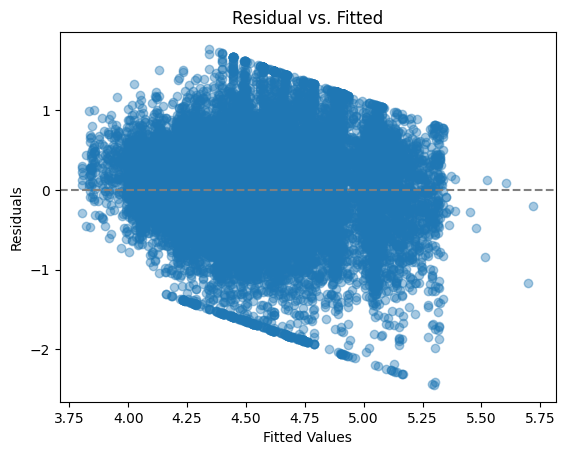

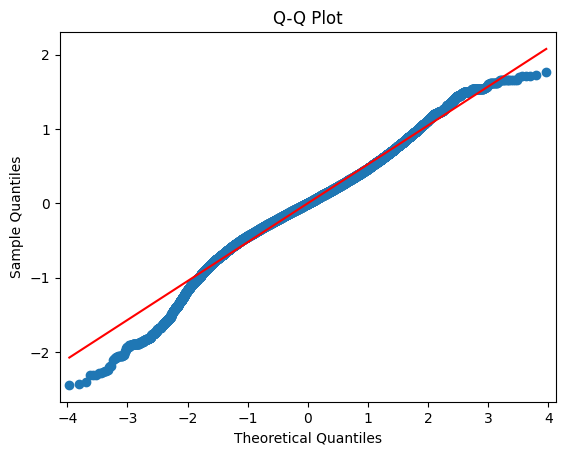

Breusch-Pagan p-value: 0.0000
    threshold  R_squared           AIC  interaction_pval
11         16   0.254173  42375.366817      1.242316e-91
12         17   0.253673  42393.773785      3.026204e-90
10         15   0.254446  42365.313135      4.089741e-89
9          14   0.254848  42350.453811      3.381682e-88
8          13   0.255344  42332.158270      3.666562e-88
13         18   0.253127  42413.915946      2.188403e-87
7          12   0.255821  42314.516908      2.331608e-87
14         19   0.252642  42431.760853      1.432964e-84
15         20   0.252345  42442.687563      1.095683e-83
16         21   0.252052  42453.450213      4.456906e-82


In [ ]:
"""
This is a quasi-experimental causal model, more specifically a threshold-based treatment-effect model.
Model Description: Threshold-Based Causal Regression 

Objective:
    Evaluate whether delivery performance (log_duration) is affected more significantly 
    when a courier is under high task load.

Main Modeling Approach:
    - The model introduces a threshold effect using:
        - task_count_c: Centered daily task count (based on median)
        - high_load: Binary indicator (1 if task_count > threshold)
        - task_count_c * high_load: Interaction term to detect if extra workload under high load worsens performance

    - Fixed effects are included for:
        - region_id (to control for regional delivery conditions)
        - hour_bin (to control for time-of-day variation)

Interpretation:
    - Baseline effect of task_count_c represents normal (low-load) days.
    - The interaction term shows: 
        "How much more does each additional task affect delivery time when the courier is already under 'high load?'"

Optimal Threshold Chosen: 16 (refer to appendix) -> !!!! Change high_load to 1 if task_count > 16 !!!!!
    - Based on a grid search optimizing R², AIC, and significance of interaction term
    - This value captures the workload transition point (low-load → high-load)

Use Cases:
    - Identifying operational tipping points
    - Policy guidance for task assignment caps or bonus triggers
    - Strategic staffing decisions during peak hours or high-demand days
"""


import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# --- Load Data ---
df = pd.read_parquet("/Users/ilseoplee/IDS701_Team_Project/Data/cleaned_data.parquet")
df["accept_hour"] = df["accept_time"].dt.hour

# --- Step 1: Filter Data for Top Regions ---
top_regions = df["region_id"].value_counts().head(14).index
df_filtered = df[df["region_id"].isin(top_regions)]

# --- Step 2: Create Daily Aggregations per Courier ---
daily_agg = (
    df_filtered.groupby(["courier_id", "accept_date"])
    .agg(
        region_id=("region_id", "first"),  # Ensure region_id is preserved
        task_count=("order_id", "nunique"),
        avg_delivery_duration_min=("delivery_duration_minutes", "mean"),
        avg_distance_km=("distance_km", "mean"),
        delivery_hour_mode=("accept_hour", lambda x: x.mode()[0]),
    )
    .reset_index()
)

# --- Step 3: Create relevant variables ---
threshold = daily_agg["task_count"].median()
daily_agg["high_load"] = (daily_agg["task_count"] > threshold).astype(int)
daily_agg["task_count_c"] = daily_agg["task_count"] - threshold

# Time binning
daily_agg["hour_bin"] = pd.cut(
    daily_agg["delivery_hour_mode"],
    bins=[0, 6, 12, 18, 24],
    labels=["Night", "Morning", "Afternoon", "Evening"],
    right=False
)

# Log transform + trim outliers
daily_agg["log_duration"] = np.log(daily_agg["avg_delivery_duration_min"].replace(0, 0.001))
q_low, q_high = daily_agg["log_duration"].quantile([0.01, 0.99])
daily_agg["log_duration"] = daily_agg["log_duration"].clip(lower=q_low, upper=q_high)

# --- Step 4: Run Regression ---
model = smf.ols(
    formula="""
        log_duration ~ task_count_c * high_load
        + avg_distance_km
        + C(region_id)
        + C(hour_bin)
    """,
    data=daily_agg
).fit(cov_type="HC3")

# --- Step 5: Results ---
print(model.summary())

# --- Step 6: VIF Check ---
X_vif = daily_agg[["task_count_c", "high_load", "avg_distance_km"]].copy()
X_vif["interaction"] = daily_agg["task_count_c"] * daily_agg["high_load"]
X_vif = sm.add_constant(X_vif)
vif_df = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
print(vif_df)

# --- Step 7: Diagnostic Plots ---
# Residual plot
plt.scatter(model.fittedvalues, model.resid, alpha=0.4)
plt.axhline(y=0, color="gray", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual vs. Fitted")
plt.show()

# Q-Q Plot
qqplot(model.resid, line="s")
plt.title("Q-Q Plot")
plt.show()

# Breusch-Pagan Test
bp_test = het_breuschpagan(model.resid, model.model.exog)
print(f"Breusch-Pagan p-value: {bp_test[1]:.4f}")  # < 0.05 implies heteroscedasticity



#### Appendix. Threshold Search ####
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

results = []
for threshold in range(5, 50):
    daily_agg["high_load"] = (daily_agg["task_count"] > threshold).astype(int)
    daily_agg["task_count_c"] = daily_agg["task_count"] - threshold

    model = smf.ols(
        formula="""
            log_duration ~ task_count_c * high_load
            + avg_distance_km
            + C(region_id)
            + C(hour_bin)
        """,
        data=daily_agg
    ).fit()

    results.append({
        "threshold": threshold,
        "R_squared": model.rsquared,
        "AIC": model.aic,
        "interaction_pval": model.pvalues.get("task_count_c:high_load", np.nan)
    })

results_df = pd.DataFrame(results)
print(results_df.sort_values("interaction_pval").head(10))